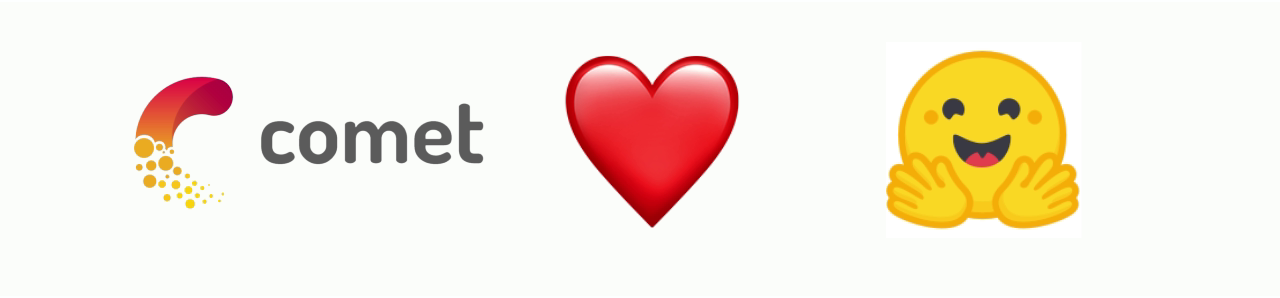

[Hugging Face](https://huggingface.co/docs) is a community and data science platform that provides tools that enable users to build, train and deploy ML models based on open source (OS) code and technologies. Primarily known for their `transformers` library, Hugging Face has helped democratized access to these models by providing a unified API to train and evaluate a number of popular models for NLP. 

Comet integrates with Hugging Face's `Trainer` object, allowing you to log your model parameters, metrics, and assets such as model checkpoints. Learn more about our integration [here](https://www.comet.com/docs/v2/integrations/ml-frameworks/huggingface/) 

Curious about how Comet can help you build better models, faster? Find out more about [Comet](https://www.comet.ml/site) and our [other integrations](https://www.comet.ml/docs/v2/integrations/overview/)

# Install Comet and Dependencies

In [ ]:
%pip install comet_ml torch datasets transformers

# Initialize Comet

In [ ]:
import comet_ml
comet_ml.init(project_name='comet-examples-transfomers-trainer')

# Set Model Type

In [ ]:
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased"
SEED = 42

# Load Data

In [ ]:
from transformers import AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

# Setup Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

#

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create Sample Datasets

For this guide, we are only going to sample 200 examples from our dataset.  

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(200))
eval_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(200))

# Setup Transformer Model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)

# Setup Evaluation Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_example(index):
    return eval_dataset[index]['text']


def compute_metrics(pred):    
    experiment = comet_ml.get_global_experiment()
    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    if experiment:
      epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
      experiment.set_epoch(epoch)
      experiment.log_confusion_matrix(
          y_true=labels, 
          y_predicted=preds, 
          file_name=f"confusion-matrix-epoch-{epoch}.json", 
          labels=['negative', 'postive'],
          index_to_example_function=get_example
      )

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Run Training

In order to enable logging from the Hugging Face Trainer, you will need to set the `COMET_MODE` environment variable to `ONLINE`.  If you would like to log assets produced in the training run as Comet Assets, set `COMET_LOG_ASSETS=TRUE`   

In [ ]:
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

training_args = TrainingArguments(
    seed=SEED,
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=1,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_total_limit=10,
    save_steps=25,
    per_device_train_batch_size=8,
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,      
  )
trainer.train()